In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json

### Read datasheet and Checking if it read properly, total 400 projects

In [2]:
df = pd.read_csv("data.csv")
print(df.dtypes)
df.shape

projectName              object
Sum                       int64
Best Practices            int64
Possible Errors           int64
Variables                 int64
                          ...  
no-constant-condition     int64
operator-assignment       int64
no-buffer-constructor     int64
no-useless-return         int64
no-undefined              int64
Length: 253, dtype: object


(400, 253)

### Create a new DataFrame df_errors only contains data of the 6 error types

In [3]:
df_errors = df.iloc[:, 0:8].copy()
df_errors.head()

,projectName,Sum,Best Practices,Possible Errors,Variables,Node.js and CommonJS,Stylistic Issues,ECMAScript6
0,leetcode-the-hard-way,254,4,0,7,0,243,0
1,osm-community-index,262,16,0,0,0,238,8
2,zigbee-OTA,283,1,0,1,0,281,0
3,escrcpy,334,1,0,1,0,332,0
4,HostlistsRegistry,340,0,0,0,0,340,0


### Read JSON file, which contains the definition of each errors

In [4]:
json_file_path = 'rulesCategory.json'

with open(json_file_path, 'r') as file:
    error_rules = json.load(file)

# Create individual DataFrames for each error type
error_dataframes = {}

for error_type in error_rules:
    error_dataframes[error_type['type']] = df[['projectName'] + [error_type['type']] + error_type['rules']].copy()

### Create 6 indiviual dataframe for each error and their belonging rules

In [5]:
# Dataset contain error type "Possible Errors" and its corresponding rules
Possible_Errors_df = error_dataframes['Possible Errors']

# Dataset contain error type "Best Practices" and its corresponding rules
Best_Practices_df = error_dataframes['Best Practices']

# Dataset contain error type "Variables" and its corresponding rules
Variables_df = error_dataframes['Variables']

# Dataset contain error type "Node.js and CommonJS" and its corresponding rules
Node_CommonJS_df = error_dataframes['Node.js and CommonJS']

# Dataset contain error type "Stylistic Issues" and its corresponding rules
Stylistic_Issues_df = error_dataframes['Stylistic Issues']

# Dataset contain error type "ECMAScript6" and its corresponding rules
ECMAScript6_df = error_dataframes['ECMAScript6']

#Stylistic_Issues_df.shape

### Compute the average of how frequently a particular error is violated across the entire dataset to give a general look

In [22]:
# Calculate portion of each error type in each project
error_portion = df_errors[['Best Practices', 'Possible Errors', 'Variables', 'Node.js and CommonJS', 'Stylistic Issues', 'ECMAScript6']].div(df_errors['Sum'], axis=0)
error_portion.columns = [f"{col}" for col in error_portion.columns]
error_portion.insert(0, 'projectName', df_errors['projectName'])

# Calculate the statistics for each error type
error_types = ['Best Practices', 'Possible Errors', 'Variables', 'Node.js and CommonJS', 'Stylistic Issues', 'ECMAScript6']
error_stats = error_portion[error_types].describe(percentiles=[.25, .5, .75])

# Extract relevant statistics (mean, max, min, Q1, median, Q3)
relevant_stats = error_stats.loc[['mean', 'max', 'min', '25%', '50%', '75%']]*100
relevant_stats = relevant_stats.rename(index={'25%': 'Q1', '50%': 'median', '75%': 'Q3'})
relevant_stats = relevant_stats.transpose()
error_average = error_portion[error_types].mean()
# Print the statistics for each error type
print(relevant_stats.round(2))


                       mean     max   min     Q1  median     Q3
Best Practices         1.95   36.12  0.00   0.15    0.84   2.59
Possible Errors        0.13    5.37  0.00   0.00    0.03   0.11
Variables              5.65   99.86  0.00   0.31    1.47   6.19
Node.js and CommonJS   0.00    0.00  0.00   0.00    0.00   0.00
Stylistic Issues      89.90  100.00  0.11  88.10   92.85  96.96
ECMAScript6            2.37   49.93  0.00   0.13    1.15   3.31


### Visulaize the data

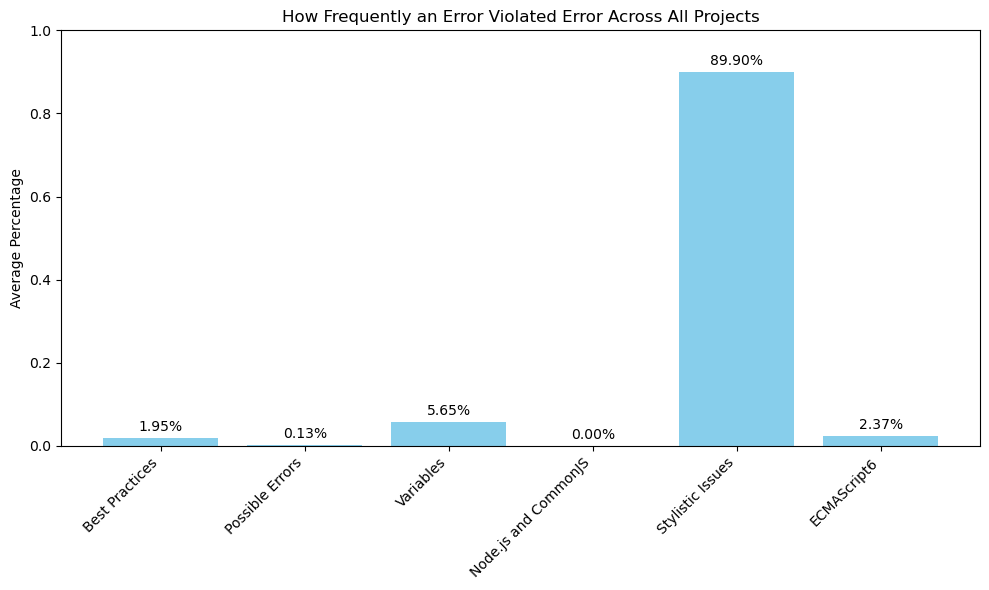

In [7]:
error_types = error_average.index
mean_values = error_average.values

plt.figure(figsize=(10, 6))
bars = plt.bar(error_types, mean_values, color='skyblue')


for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2%}', ha='center', va='bottom')

plt.xlabel('')
plt.ylabel('Average Percentage')
plt.title('How Frequently an Error Violated Error Across All Projects')


plt.xticks(rotation=45, ha='right')

plt.ylim(0, 1)  
plt.tight_layout()  
plt.show()

### Compute the average of how frequently a particular rules is violated across the entire dataset to give a general look

/tmp/ipykernel_215/3454634544.py:22: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_proportions = top_rules.append(pd.Series({'Other': other_proportion}))


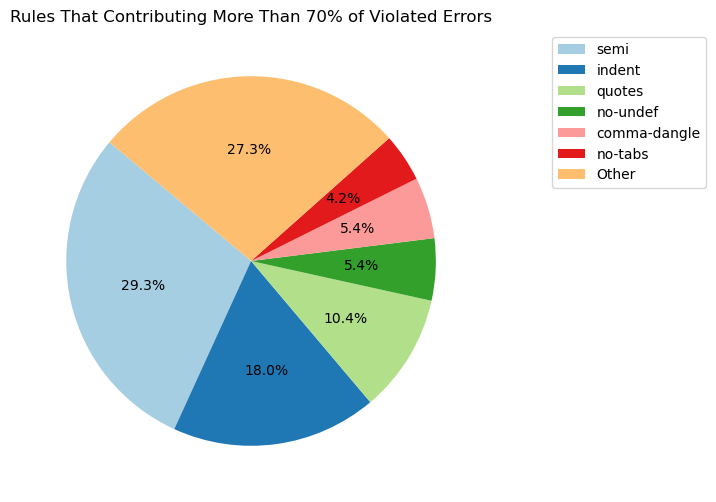

In [8]:
# Assuming df contains the relevant columns for error rules
all_rules = df.columns[8:]  # Assuming error rules start from the 8th column
error_rules_portion = df[all_rules].div(df['Sum'], axis=0)  # Calculate portion of each rule in each project
error_rules_portion_average = error_rules_portion.mean()  # Calculate the average portion of each rule

# Sort the rules based on average portion in descending order
average_rules_portion_sorted = error_rules_portion_average.sort_values(ascending=False)

# Calculate the cumulative sum of proportions
cumulative_sum = average_rules_portion_sorted.cumsum()

# Find the index where the cumulative sum crosses 70%
threshold_index = (cumulative_sum >= 0.7).idxmax()

# Extract the top rules that contribute 70% or more
top_rules = average_rules_portion_sorted[:threshold_index]

# Calculate the proportion of 'Other' rules
other_proportion = 1 - top_rules.sum()

# Combine top rules and 'Other' into a single Series
combined_proportions = top_rules.append(pd.Series({'Other': other_proportion}))

# Plot the pie chart without labels
plt.figure(figsize=(10, 6))
plt.pie(combined_proportions, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)

# Add legend at the top right corner
plt.legend(combined_proportions.index, loc="upper right", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Rules That Contributing More Than 70% of Violated Errors')
plt.show()

### Stylistic Issue

#### Dive deep into error "Stylistic Issues"

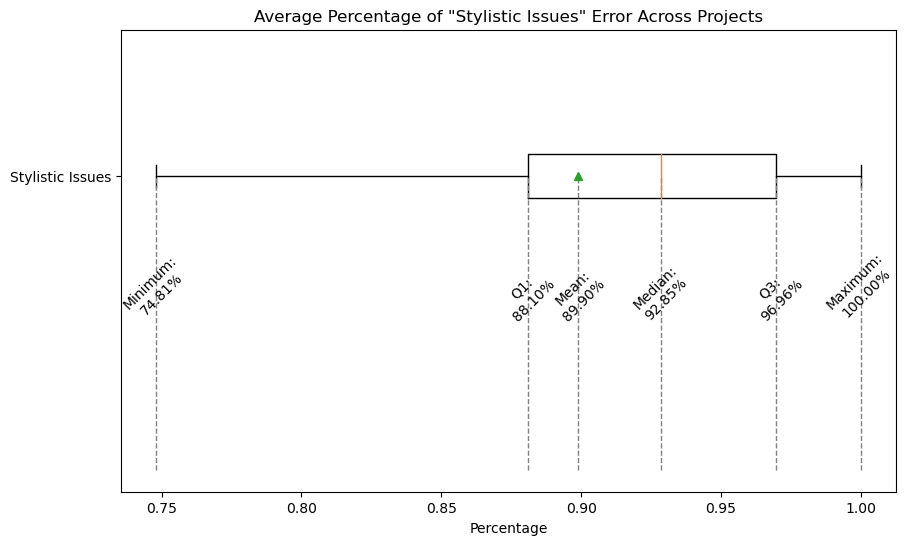

In [9]:
# Create boxplot for error type 'Stylistic Issues'
stylistic_issues_distribution = error_portion['Stylistic Issues']

plt.figure(figsize=(10, 6))
box = plt.boxplot(stylistic_issues_distribution, vert=False, showfliers=False, showmeans=True)

stats = {
    'Minimum': box['whiskers'][0].get_xdata()[1],
    'Maximum': box['whiskers'][1].get_xdata()[1],
    'Q1': box['boxes'][0].get_xdata()[0],
    'Median': box['medians'][0].get_xdata()[0],
    'Q3': box['boxes'][0].get_xdata()[2],
    'Mean': box['means'][0].get_xdata()[0],
}

# Display statistics on the plot 
for stat, value in stats.items():
    plt.plot([value, value], [0, 1], color='gray', linestyle='--', linewidth=1)  
    plt.text(value, 0.5, f'{stat}:\n{value:.2%}', rotation=45, ha='center', va='bottom')  

plt.plot([stats['Minimum'], stats['Minimum']], [0.2, 0.2], color='red', linestyle='-', linewidth=1.5)  
plt.plot([stats['Maximum'], stats['Maximum']], [0.2, 0.2], color='blue', linestyle='-', linewidth=1.5)  

plt.xlabel('Percentage')
plt.title('Average Percentage of "Stylistic Issues" Error Across Projects')

# Set y-axis label
plt.yticks([1], ['Stylistic Issues'])

plt.show()


#### Top 5 most frequently violated rules in 'Stylistic Issues'

In [30]:
# Calculate the mean portion of each rules for error Stylistic issues
stylistic_issues_means = Stylistic_Issues_df.drop(columns=['projectName']).mean()
stylistic_issues_means = stylistic_issues_means[1:].sort_values(ascending=False)
print("Top 5 most frequently violated rules from Stylistic Issues")
print(stylistic_issues_means.head())

Top 5 most frequently violated rules from Stylistic Issues
indent             29895.8125
semi               21138.9850
quotes             17160.9600
comma-spacing      15063.6325
space-infix-ops    13292.1200
dtype: float64


/tmp/ipykernel_215/3421321064.py:9: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wedges, texts, autopcts = ax.pie(top_rules.append(pd.Series([combined_value], index=[combined_label])),


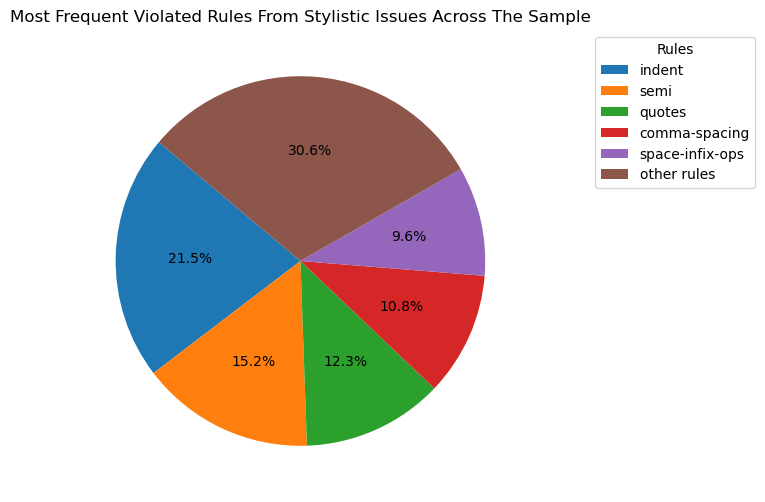

In [31]:
top_rules = stylistic_issues_means.head(5)
other_rules = stylistic_issues_means.iloc[5:]
# Combine other rules into a single value
combined_value = other_rules.sum()
combined_label = f'other rules'

# Plot the pie chart with the top 5 rules and "Other"
fig, ax = plt.subplots(figsize=(10, 6))
wedges, texts, autopcts = ax.pie(top_rules.append(pd.Series([combined_value], index=[combined_label])),
                                 autopct='%1.1f%%', startangle=140)

for autopct, label in zip(autopcts, top_rules.index.append(pd.Index([combined_label]))):
    autopct.set_text(f'{autopct.get_text()}')

legend_labels = top_rules.index.append(pd.Index([combined_label]))
ax.legend(wedges, legend_labels, title="Rules", loc="upper right", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Most Frequent Violated Rules From Stylistic Issues Across The Sample')
plt.show()

### Continues on the other error types

In [23]:
# Print the statistics for each error type
print(relevant_stats.round(2))

                       mean     max   min     Q1  median     Q3
Best Practices         1.95   36.12  0.00   0.15    0.84   2.59
Possible Errors        0.13    5.37  0.00   0.00    0.03   0.11
Variables              5.65   99.86  0.00   0.31    1.47   6.19
Node.js and CommonJS   0.00    0.00  0.00   0.00    0.00   0.00
Stylistic Issues      89.90  100.00  0.11  88.10   92.85  96.96
ECMAScript6            2.37   49.93  0.00   0.13    1.15   3.31


### Variables

In [28]:
# Calculate the mean portion of each rules for Variables 
Variables_means = Variables_df.drop(columns=['projectName']).mean()
Variables_means = Variables_means[1:].sort_values(ascending=False)
print("Top 5 most frequently violated rules from Variables")
print(Variables_means.head())

Top 5 most frequently violated rules from Variables
no-undef                      2950.6100
no-unused-vars                 131.9825
no-use-before-define            20.2350
no-shadow-restricted-names       4.4775
no-undef-init                    3.9900
dtype: float64


/tmp/ipykernel_215/638521807.py:9: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wedges, texts, autopcts = ax.pie(top_rules.append(pd.Series([combined_value], index=[combined_label])),


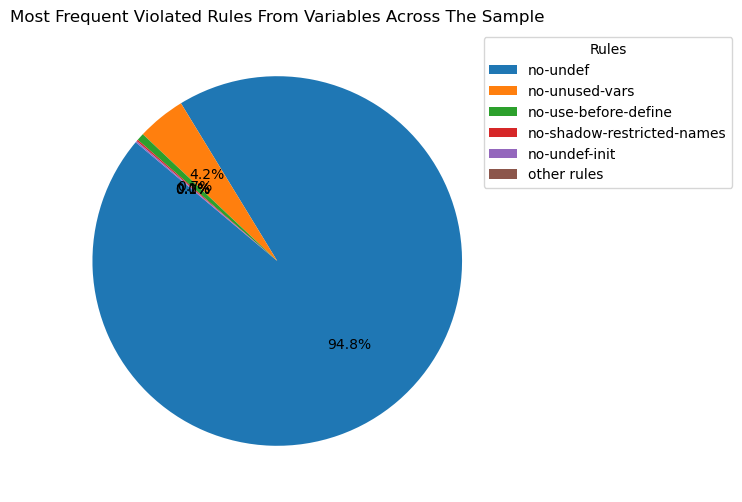

In [60]:
top_rules = Variables_means.head(5)
other_rules = Variables_means.iloc[5:]
# Combine other rules into a single value
combined_value = other_rules.sum()
combined_label = f'other rules'

# Plot the pie chart with the top 5 rules and "Other"
fig, ax = plt.subplots(figsize=(10, 6))
wedges, texts, autopcts = ax.pie(top_rules.append(pd.Series([combined_value], index=[combined_label])),
                                 autopct='%1.1f%%', startangle=140)

for autopct, label in zip(autopcts, top_rules.index.append(pd.Index([combined_label]))):
    autopct.set_text(f'{autopct.get_text()}')

legend_labels = top_rules.index.append(pd.Index([combined_label]))
ax.legend(wedges, legend_labels, title="Rules", loc="upper right", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Most Frequent Violated Rules From Variables Across The Sample')
plt.show()

### Possible Errors

In [29]:
# Calculate the mean portion of each rules for Possible Errors
Possible_Errors_means = Possible_Errors_df.drop(columns=['projectName']).mean()
Possible_Errors_means = Possible_Errors_means[1:].sort_values(ascending=False)
print("Top 5 most frequently violated rules from Possible Errors")
print(Possible_Errors_means.head())

Top 5 most frequently violated rules from Possible Errors
no-extra-parens                122.9225
no-prototype-builtins           28.7950
no-template-curly-in-string     15.7150
no-cond-assign                  14.7525
no-func-assign                   7.3225
dtype: float64


/tmp/ipykernel_215/1521928918.py:9: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wedges, texts, autopcts = ax.pie(top_rules.append(pd.Series([combined_value], index=[combined_label])),


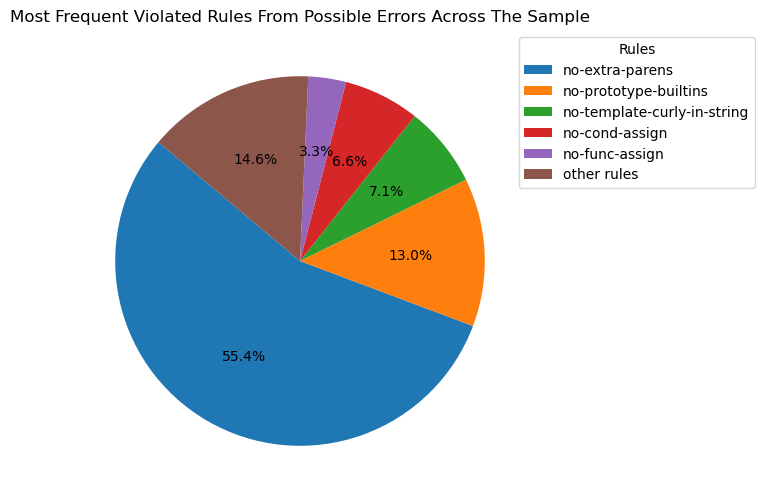

In [61]:
top_rules = Possible_Errors_means.head(5)
other_rules = Possible_Errors_means.iloc[5:]
# Combine other rules into a single value
combined_value = other_rules.sum()
combined_label = f'other rules'

# Plot the pie chart with the top 5 rules and "Other"
fig, ax = plt.subplots(figsize=(10, 6))
wedges, texts, autopcts = ax.pie(top_rules.append(pd.Series([combined_value], index=[combined_label])),
                                 autopct='%1.1f%%', startangle=140)

for autopct, label in zip(autopcts, top_rules.index.append(pd.Index([combined_label]))):
    autopct.set_text(f'{autopct.get_text()}')

legend_labels = top_rules.index.append(pd.Index([combined_label]))
ax.legend(wedges, legend_labels, title="Rules", loc="upper right", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Most Frequent Violated Rules From Possible Errors Across The Sample')
plt.show()

### Best practices

In [32]:
# Calculate the mean portion of each rules for Best practices
Best_Practices_means = Best_Practices_df.drop(columns=['projectName']).mean()
Best_Practices_means = Best_Practices_means[1:].sort_values(ascending=False)
print("Top 5 most frequently violated rules from Best practices")
print(Best_Practices_means.head())

Top 5 most frequently violated rules from Best practices
eqeqeq                   622.7900
no-sequences             549.8075
no-unused-expressions    530.1725
yoda                     474.9325
no-labels                445.5950
dtype: float64


/tmp/ipykernel_215/251785157.py:9: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wedges, texts, autopcts = ax.pie(top_rules.append(pd.Series([combined_value], index=[combined_label])),


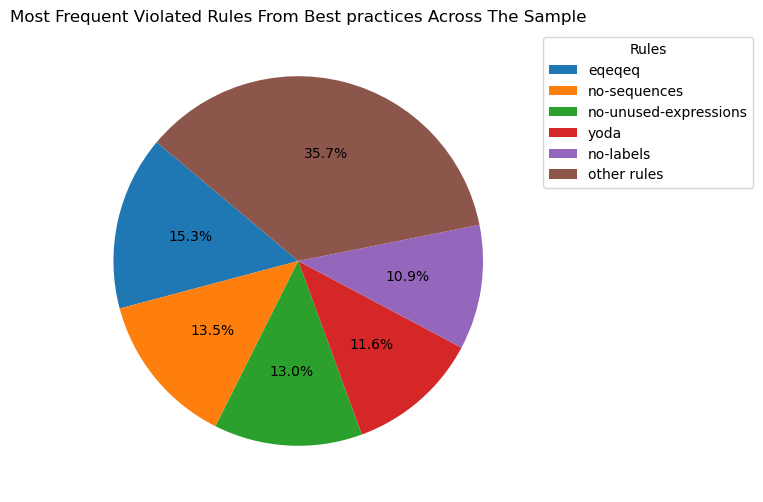

In [62]:
top_rules = Best_Practices_means.head(5)
other_rules = Best_Practices_means.iloc[5:]
# Combine other rules into a single value
combined_value = other_rules.sum()
combined_label = f'other rules'

# Plot the pie chart with the top 5 rules and "Other"
fig, ax = plt.subplots(figsize=(10, 6))
wedges, texts, autopcts = ax.pie(top_rules.append(pd.Series([combined_value], index=[combined_label])),
                                 autopct='%1.1f%%', startangle=140)

for autopct, label in zip(autopcts, top_rules.index.append(pd.Index([combined_label]))):
    autopct.set_text(f'{autopct.get_text()}')

legend_labels = top_rules.index.append(pd.Index([combined_label]))
ax.legend(wedges, legend_labels, title="Rules", loc="upper right", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Most Frequent Violated Rules From Best practices Across The Sample')
plt.show()